# Import library dan dataset yang digunakan

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn import set_config

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

In [4]:
customer_df = pd.read_csv('Mall_Customers.csv')

customer_df = customer_df.drop('CustomerID', axis=1)
customer_df = customer_df.rename(index=str, columns={
    'Annual Income (k$)': 'Income',
    'Spending Score (1-100)': 'SpendingScore'
})

In [5]:
print('Shape: ', customer_df.shape)

print('---')
print(customer_df.dtypes)

print('---')
print(customer_df.describe())

print('---')
print(customer_df.isnull().sum())

Shape:  (200, 4)
---
Gender           object
Age               int64
Income            int64
SpendingScore     int64
dtype: object
---
              Age      Income  SpendingScore
count  200.000000  200.000000     200.000000
mean    38.850000   60.560000      50.200000
std     13.969007   26.264721      25.823522
min     18.000000   15.000000       1.000000
25%     28.750000   41.500000      34.750000
50%     36.000000   61.500000      50.000000
75%     49.000000   78.000000      73.000000
max     70.000000  137.000000      99.000000
---
Gender           0
Age              0
Income           0
SpendingScore    0
dtype: int64


# User Profile

In [6]:
fig = px.pie(
    data_frame=customer_df, 
    names='Gender', 
    title='Customer Genders', 
    hole=0.1, 
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig.show()

Dari user profile pertama didapati pelanggan wanita lebih banyak dibanding pria dengan persentase 56% pelanggan wanita, 12% lebih tinggi dibanding pria

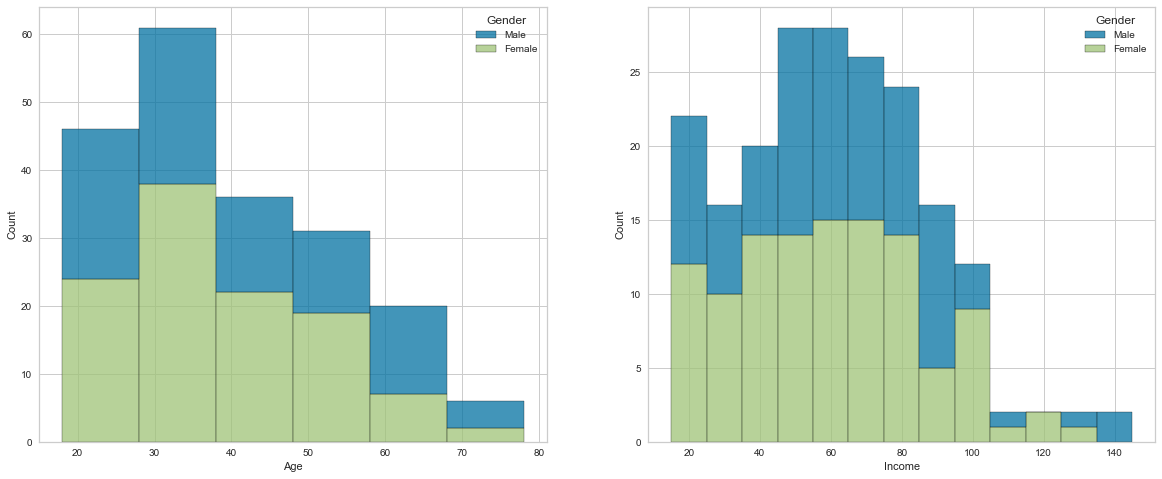

In [7]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 8))

sns.histplot(data=customer_df, x='Age', hue='Gender', binwidth=10, multiple='stack', ax=ax0)
sns.histplot(data=customer_df, x='Income', hue='Gender', binwidth=10, multiple='stack', ax=ax1);

Pada diagram diatas maka ditemukan bahwa rentang umur 20-40 merupakan kelompok usia yang paling banyak memiliki anggota, Kelompok usia pelanggan terbesar adalah pelanggan berusia 30 tahun (kebanyakan wanita, dan Sebagian besar pelanggan menghasilkan antara $50k$  dan $80k$ per tahun

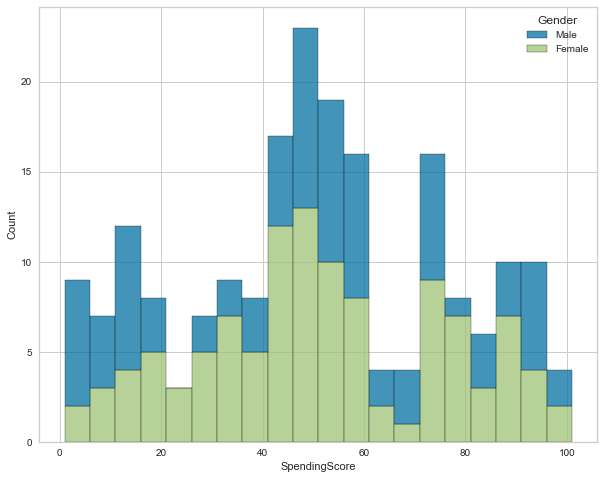

In [8]:
plt.figure(figsize=(10, 8))

sns.histplot(data=customer_df, x='SpendingScore', hue='Gender', binwidth=5, multiple='stack');

Skor pengeluaran memiliki beberapa kelompok:
antara 0 dan 20 (laki-laki mendominasi)
antara 25 dan 40 (wanita mendominasi)
antara 45 dan 60 (wanita mendominasi)
antara 65 dan 70 (laki-laki mendominasi)
antara 70 dan 100 (wanita mendominasi)

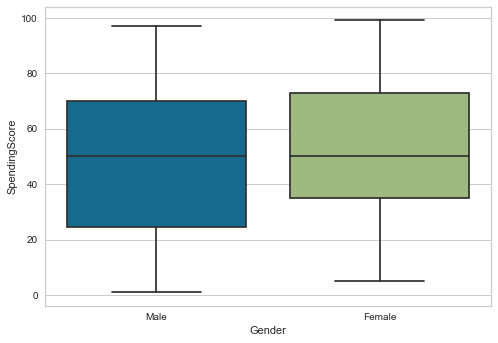

In [9]:
sns.boxplot(data=customer_df, x='Gender', y='SpendingScore');

Wanita cenderung menghabiskan lebih banyak seperti yang kita lihat dari batas bawah
Rata-rata, wanita hanya menghabiskan sedikit lebih banyak daripada pria

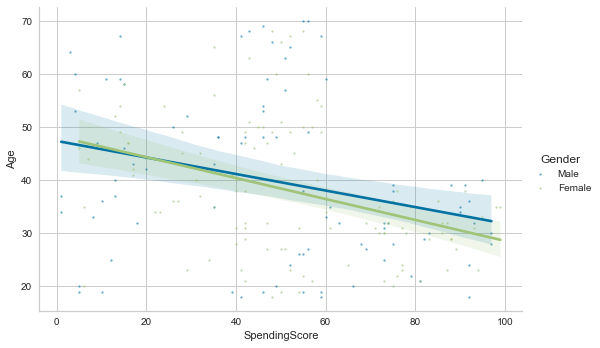

In [10]:
sns.lmplot(
    data=customer_df,
    x='SpendingScore', 
    y='Age', 
    hue='Gender',
    aspect=1.5,
    scatter_kws={'s': 5, 'alpha': 0.6}
);

Ada ketergantungan linier antara Skor Pengeluaran dan Usia. Pelanggan yang lebih muda cenderung memiliki skor pengeluaran yang lebih tinggi dan skor pengeluaran menurun ketika usia bertambah.

In [11]:
def impute_spending_group(spending_score):
    if spending_score <= 35:
        return 'low'
    if spending_score > 35 and spending_score <= 65:
        return 'medium'
    if spending_score > 65:
        return 'high'

customer_df['SpendingGroup'] = customer_df['SpendingScore'].apply(impute_spending_group)

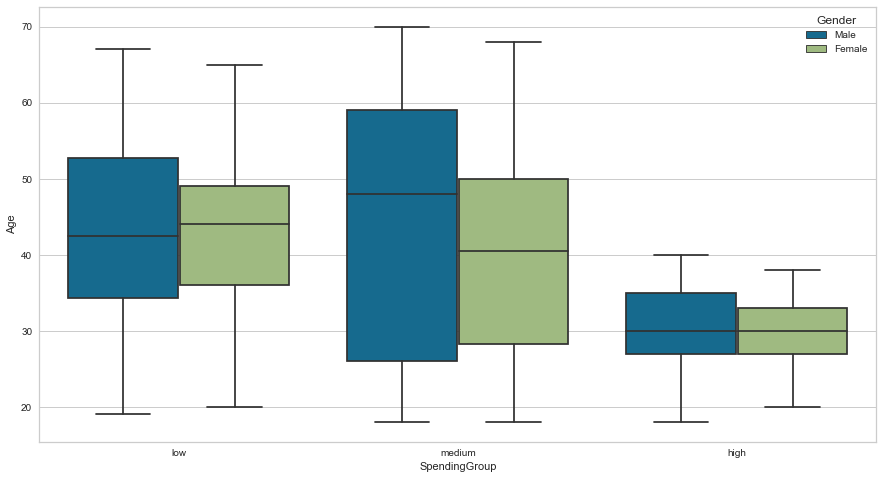

In [12]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=customer_df, x='SpendingGroup', y='Age', hue='Gender', order=['low', 'medium', 'high']);

Dari plot Kelompok Pengeluaran - Usia terlihat bahwa variasi terendah terdapat pada kelompok pengeluaran tinggi. Anggotanya berada dalam kelompok usia 20-40 tahun. Kelompok pengeluaran rendah dan menengah tampaknya secara kasar mencakup seluruh rentang usia.

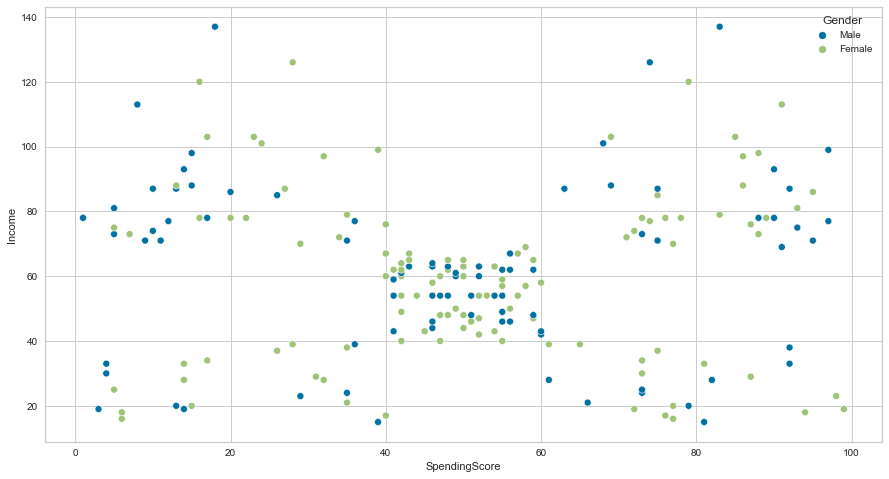

In [13]:
plt.figure(figsize=(15, 8))

sns.scatterplot(data=customer_df, x='SpendingScore', y='Income', hue='Gender');

lima cluster yang dapat dikenali secara visual tampaknya mewakili pelanggan yang:
- memiliki pendapatan tinggi dan skor pengeluaran rendah
- pendapatan rendah dan skor pengeluaran rendah
- pendapatan tinggi dan skor pengeluaran rendah
- pendapatan tinggi dan skor pengeluaran tinggi
- klaster menengah padat dengan skor pendapatan menengah dan pengeluaran menengah

# Proses data mining menggunakan K-Means

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [15]:
data_processor = Pipeline([
    ('processing', ColumnTransformer([
            ('gender_encoder', OrdinalEncoder(), ['Gender']),
            ('spending_group_encoder', OrdinalEncoder(categories=[['low', 'medium', 'high']]), ['SpendingGroup']),
        ], remainder='passthrough')
    )
])

data_processor

Pipeline(steps=[('processing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('gender_encoder',
                                                  OrdinalEncoder(),
                                                  ['Gender']),
                                                 ('spending_group_encoder',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high']]),
                                                  ['SpendingGroup'])]))])

In [16]:
X = data_processor.fit_transform(customer_df)

In [17]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

sns.set_palette('Set2')
set_config(display='diagram')

heatcmap = sns.diverging_palette(230, 20, as_cmap=True)

In [18]:
from sklearn.cluster import KMeans

kmean_model = KMeans(random_state=RANDOM_SEED)

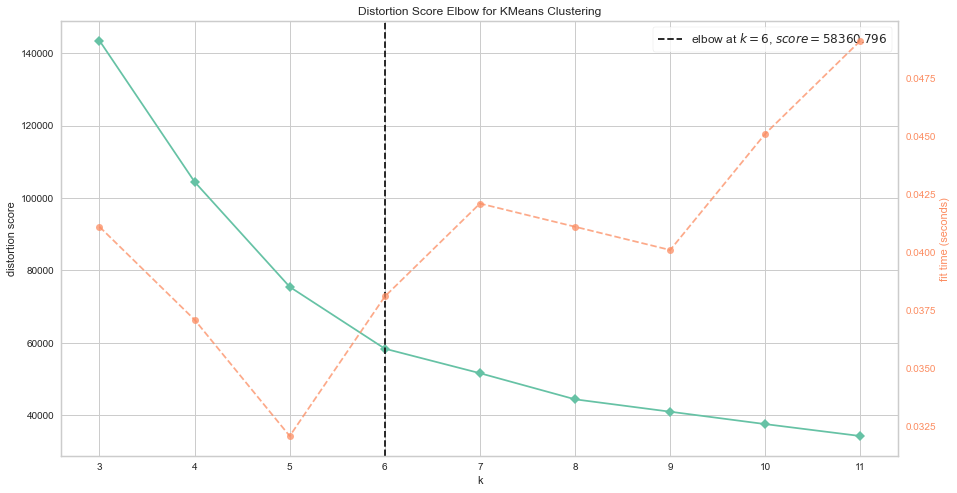

In [19]:
plt.figure(figsize=(15, 8))

elbow_visualizer = KElbowVisualizer(kmean_model, k=(3, 12))

elbow_visualizer.fit(X)
elbow_visualizer.show();

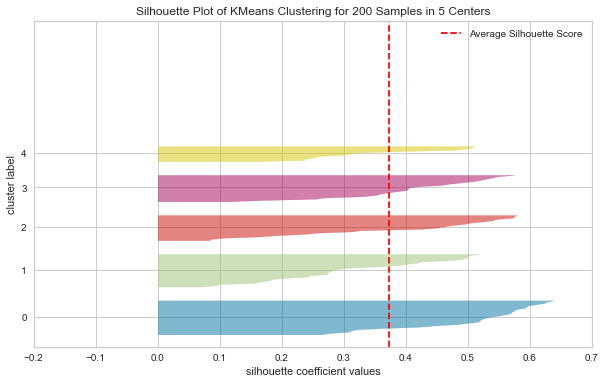

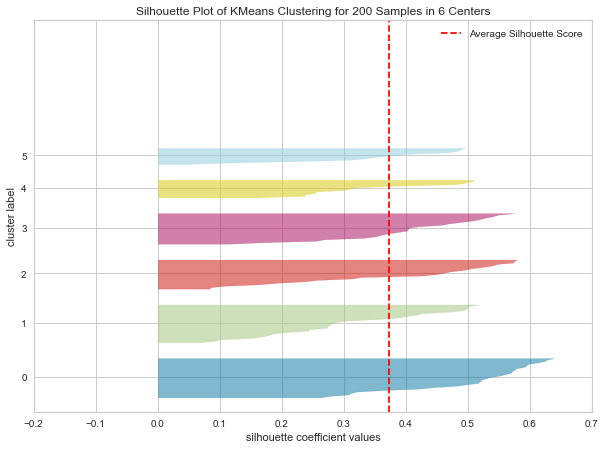

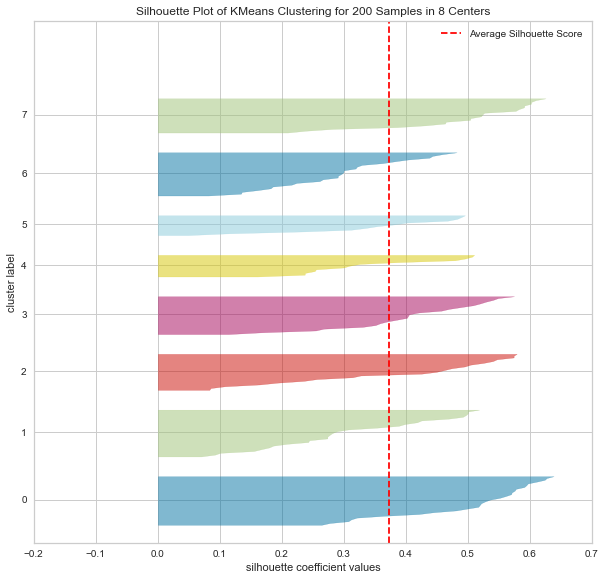

In [20]:
for idx, n_clusters in enumerate([5, 6, 8]):
    plt.figure(figsize=(10, n_clusters * 1.2))
    
    kmean_model.n_clusters = n_clusters
    silhouette_visualizer = SilhouetteVisualizer(kmean_model, colors='yellowbrick')

    silhouette_visualizer.fit(X);
    silhouette_visualizer.show();

In [21]:
kmean_model = KMeans(n_clusters=8, random_state=RANDOM_SEED)

kmean_model.fit(X)

kmean_clusters = kmean_model.labels_
kmean_centroids = kmean_model.cluster_centers_

In [22]:
customer_df['Cluster'] = kmean_clusters

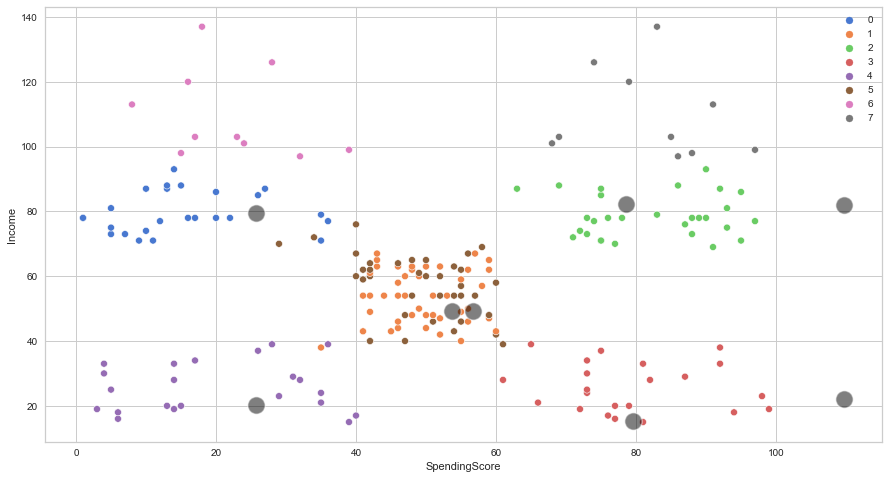

In [23]:
plt.figure(figsize=(15, 8))

sns.scatterplot(data=customer_df, x='SpendingScore', y='Income', hue='Cluster', palette='muted');
sns.scatterplot(x=kmean_centroids[:, 3], y=kmean_centroids[:, 4], color='black', s=300, alpha=0.5);

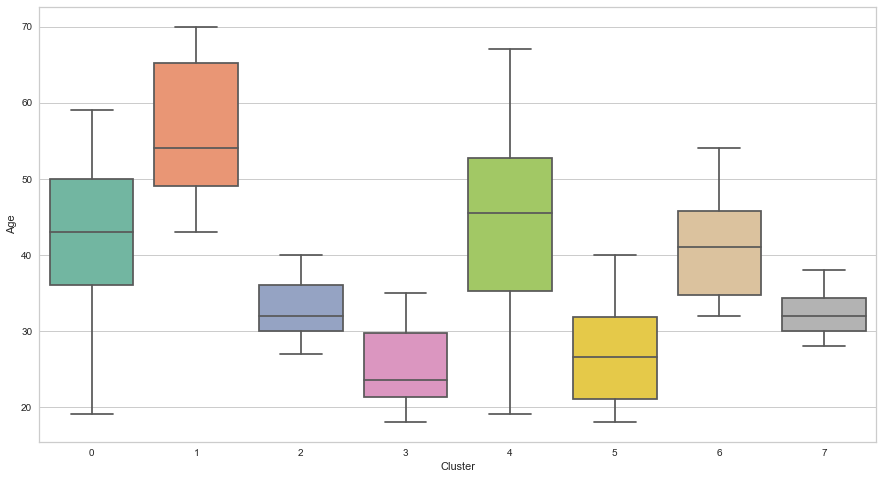

In [24]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=customer_df, x='Cluster', y='Age');

In [25]:
import plotly.express as px

fig = px.scatter_3d(
    customer_df,
    x='Age', 
    y='SpendingScore', 
    z='Income', 
    color=kmean_clusters.astype(str),
    opacity=0.8,
    height=700,
    width=700,
    title='Clusters in Age-SpendingScore-Income space',
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig.show()

Plot Age-SpendingScore-Income melakukan pekerjaan yang baik dalam membedakan kelompok kami.

Hanya dengan melihat plot 3d ini, kita dapat melihat wawasan tentang cluster berikut:

- Klaster 0 - Skor Pengeluaran Rendah, Pendapatan Menengah Atas, Usia Pertengahan
- Klaster 1 - Skor Pengeluaran Tengah, Pendapatan Menengah, Usia Tua
- Klaster 2 - Skor Pengeluaran Tinggi, Pendapatan menengah ke atas, Usia Pertengahan
- Klaster 3 - Skor Pengeluaran Tinggi, Pendapatan Rendah, Usia Muda
- Klaster 4 - Skor Pengeluaran Rendah, Pendapatan Rendah, Semua Umur
- Klaster 5 - Skor Pengeluaran Tengah, Pendapatan Menengah, Usia Muda
- Kluster 6 - Skor Pengeluaran Rendah, Pendapatan Tinggi, Usia Pertengahan
- Klaster 7 - Skor Pengeluaran Tinggi, Pendapatan Tinggi, Usia Pertengahan

Plot Gender-SpendingScore-Income juga dicoba tetapi tidak memberikan banyak informasi yang berarti bahwa gender bukanlah faktor yang signifikan untuk dataset yang diberikan.